Pixel size: 1.08 x 1.08 cm  (square)
Coverage: 92.27%


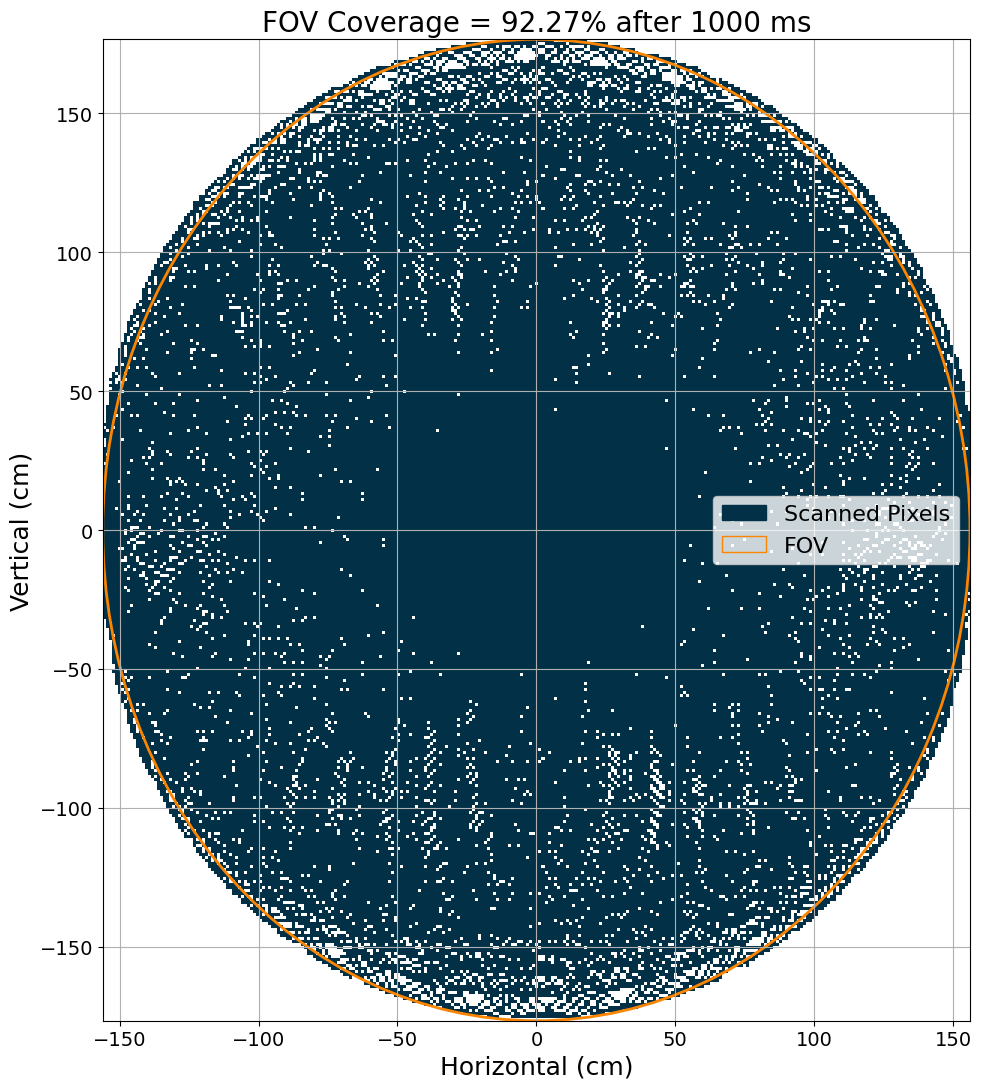

In [ ]:
import laspy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Patch
import matplotlib.colors as mcolors

LAS_FILE = "5sec_C2_1000ms.las"
scan_time = 1000
pixel_mode = "square"       # "square" or "rectangular" depending on the pixel estimation you want to use

#beam divergence (degrees)
div_h = 0.03
div_v = 0.28

#FOV (degrees)
fov_h = 70.4
fov_v = 77.2

#Load LAS
las = laspy.read(LAS_FILE)
x = las.x
y = las.y * - 1     # flip y (otherwise the plot is mirrored)
z = las.z

#Simpe Scanner to Wall distance estimation to estimate footprint and fov size
dist = np.mean(x)

#Footprint size (cm)
fp_h = 2 * dist * np.tan(np.deg2rad(div_h/2)) * 100
fp_v = 2 * dist * np.tan(np.deg2rad(div_v/2)) * 100

#Pixel size
if pixel_mode == "square":
    pix = fp_v
    px_w = pix
    px_h = pix
else:
    px_w = fp_h
    px_h = fp_v

#FOV in cm
fov_w = 2 * dist * np.tan(np.deg2rad(fov_h/2)) * 100
fov_hh = 2 * dist * np.tan(np.deg2rad(fov_v/2)) * 100

#Grid size
Gw = int(np.ceil(fov_w / px_w))
Gh = int(np.ceil(fov_hh / px_h))
grid = np.zeros((Gh, Gw), dtype=np.int32)

#Coordinate bounds
y_min = -fov_w/2
z_min = -fov_hh/2

#Convert to cm
yc = y * 100
zc = z * 100

#Map hits to grid
cx = ((yc - y_min) // px_w).astype(int)
cy = ((zc - z_min) // px_h).astype(int)

valid = (cx >= 0) & (cx < Gw) & (cy >= 0) & (cy < Gh)
np.add.at(grid, (cy[valid], cx[valid]), 1)

#FOV mask (ellipse)
yy, xx = np.mgrid[0:Gh, 0:Gw]
xxc = y_min + (xx + 0.5) * px_w
yyc = z_min + (yy + 0.5) * px_h
mask = ((xxc/(fov_w/2))**2 + (yyc/(fov_hh/2))**2) <= 1

#Coverage metrics (hit = ≥1)
covered = np.count_nonzero((grid >= 1) & mask)
total = np.count_nonzero(mask)
coverage_pct = 100 * covered / total

print(f"Pixel size: {px_w:.2f} x {px_h:.2f} cm  ({pixel_mode})")
print(f"Coverage: {coverage_pct:.2f}%")

#Plot
fig, ax = plt.subplots(figsize=(11, 11))
colors = ['#FFFFFF', '#023047', '#023047']
cmap = mcolors.ListedColormap(colors)
ax.imshow((grid >= 1), extent=[-fov_w/2, fov_w/2, -fov_hh/2, fov_hh/2], origin='lower', cmap=cmap)

#Plot FOV ellipse egde
ax.add_patch(Ellipse((0,0), fov_w, fov_hh, edgecolor='#fb8500', fc='none', lw=2, label="FOV"))
ax.legend(handles=[Patch(color='#023047', label='Scanned Pixels'), Patch(edgecolor='#fb8500', fc='none', label='FOV')], fontsize=16)

ax.set_title(f"FOV Coverage = {coverage_pct:.2f}% after {scan_time} ms", fontsize=20)
ax.set_xlabel("Horizontal (cm)", fontsize=18)
ax.set_ylabel("Vertical (cm)", fontsize=18)
ax.tick_params(labelsize=14)
ax.set_aspect("equal")
plt.grid(True)
plt.tight_layout()
plt.show()
